In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas_datareader as pdr
import pandas_datareader.famafrench
from functools import reduce
import datetime

In [2]:
#Get all the datasets 
pandas_datareader.famafrench.get_available_datasets()

['F-F_Research_Data_Factors',
 'F-F_Research_Data_Factors_weekly',
 'F-F_Research_Data_Factors_daily',
 'F-F_Research_Data_5_Factors_2x3',
 'F-F_Research_Data_5_Factors_2x3_daily',
 'Portfolios_Formed_on_ME',
 'Portfolios_Formed_on_ME_Wout_Div',
 'Portfolios_Formed_on_ME_Daily',
 'Portfolios_Formed_on_BE-ME',
 'Portfolios_Formed_on_BE-ME_Wout_Div',
 'Portfolios_Formed_on_BE-ME_Daily',
 'Portfolios_Formed_on_OP',
 'Portfolios_Formed_on_OP_Wout_Div',
 'Portfolios_Formed_on_OP_Daily',
 'Portfolios_Formed_on_INV',
 'Portfolios_Formed_on_INV_Wout_Div',
 'Portfolios_Formed_on_INV_Daily',
 '6_Portfolios_2x3',
 '6_Portfolios_2x3_Wout_Div',
 '6_Portfolios_2x3_weekly',
 '6_Portfolios_2x3_daily',
 '25_Portfolios_5x5',
 '25_Portfolios_5x5_Wout_Div',
 '25_Portfolios_5x5_Daily',
 '100_Portfolios_10x10',
 '100_Portfolios_10x10_Wout_Div',
 '100_Portfolios_10x10_Daily',
 '6_Portfolios_ME_OP_2x3',
 '6_Portfolios_ME_OP_2x3_Wout_Div',
 '6_Portfolios_ME_OP_2x3_daily',
 '25_Portfolios_ME_OP_5x5',
 '25_Portf

In [3]:
ff = pdr.get_data_famafrench('10_Industry_Portfolios', 1926)

In [4]:
type(ff)

dict

In [5]:
ff.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 'DESCR'])

In [6]:
ff.keys()
ten_ind = ff[1]

In [7]:
#Let's break apart all the industries we are looking at
industry_name = [i for i in ff[0].columns]
industry_name

['NoDur',
 'Durbl',
 'Manuf',
 'Enrgy',
 'HiTec',
 'Telcm',
 'Shops',
 'Hlth ',
 'Utils',
 'Other']

In [8]:
ten_ind = ten_ind.resample('Q').apply(lambda x: (1+ (x/100)).product()-1)
#ten_ind

In [9]:
type(ten_ind)

pandas.core.frame.DataFrame

We have gotten all the data from 1926 for different industries. Here are the industries:

1) Consumer Nondurables: Food, Tobacco, Textiles, Apparel, Leather, Toys
2) Consumer Durables -- Cars, TVs, Furniture, Household Appliances
3) Manufacturing -- Machinery, Trucks, Planes, Chemicals, Off Furn, Paper, Com Printing
4) Oil, Gas, and Coal Extraction and Products
5) Business Equipment -- Computers, Software, and Electronic Equipment
6) Telephone and Television Transmission
7) Wholesale, Retail, and Some Services (Laundries, Repair Shops)
8) Healthcare, Medical Equipment, and Drugs
9) Utilities
10) Other -- Mines, Constr, BldMt, Trans, Hotels, Bus Serv, Entertainment, Finance

The next step will be to gather important economic data from the Federal Reserve and map it alongside the data. First question is what do we want to map?
We will do our best to get variables that will not impact one specific industry. 
However, there may be data that skew towards a specific industry. We will highlight the bias.

According to https://groww.in/blog/macroeconomic-factors-that-influence-us-stock-markets

Gross Domestic Product (GDP)
Inflation
Unemployment Rate (Payrolls)
Retail Sales
Industrial Output
We will also get market data on interest rates, corporate profits, and corporate debt.

Get the data from Federal Reserve Economic Data (FRED)

Another Hypothesis is that markets will react to any economic indicators quickly. Since indicators such as GDP are lagging indicators, we will need market representations (such as yield spreads) that can help understand how stocks react to the propsect of economic events.

In [10]:
#First, let us use the common models and then we can use some of the proxies later on.
#RGDP = Real GDP... since we will examine inflation later
rgdp = pdr.get_data_fred('GDPC1', 1950)
rgdp = rgdp.pct_change().dropna()
rgdp.index = rgdp.index.to_period('Q')
#rgdp.head()

In [11]:
#CPI to capture inflation
cpi = pdr.get_data_fred('CPIAUCSL',1947)
cpi = cpi.pct_change().dropna()
cpi = cpi.resample('Q').apply(lambda x: (1+ x).product()-1)
cpi.index = cpi.index.to_period('Q')
#cpi

In [12]:
#Corporate Profits
corp_profit = pdr.get_data_fred('CP', 1947)
corp_profit = corp_profit.pct_change().dropna()
corp_profit.index = corp_profit.index.to_period('Q')
#corp_profit

In [13]:
#Unemployment Rate
unemp = pdr.get_data_fred('UNRATE', 1948)
unemp = unemp.pct_change().dropna()
unemp = unemp.resample('Q').mean()
unemp.index = unemp.index.to_period('Q')
#unemp

In [14]:
#Interest Rates (10 yr treasury rates)
irate = pdr.get_data_fred('FEDFUNDS', 1953)
irate = irate.pct_change().dropna()
irate = irate.resample('Q').apply(lambda x: (1+x).product()-1)
irate.index = irate.index.to_period('Q')
#irate

In [15]:
#We need to put the data together into a table. Additionally, we will need to group by quarters.
dfs = [ten_ind, rgdp, cpi, corp_profit, unemp, irate]

In [16]:
merged_df = ten_ind
for i in range(len(dfs)-1):
    if dfs[i].index[0] > dfs[i+1].index[0]:
        merged_df = merged_df.merge(dfs[i+1], how = 'left' , left_index= True, right_index = True)
    else:
        merged_df = merged_df.merge(dfs[i+1], how = 'right' , left_index= True, right_index = True)
#Since there was not as much data for Q1 2023, we excluded that from the dataset
merged_df = merged_df[:-1]
#merged_df

Begin running the regressions to predict the sensitivity of markets to other events.

In [17]:
from sklearn.linear_model import LinearRegression

In [18]:
#Create a separate list with all the independent variables
ind_var = []
for col in merged_df.columns[10:]:
    ind_var += [col]

In [19]:
X = merged_df[ind_var]

In [20]:
#We will now run the regression 
#We will use a for loop and try to store the values into a dictionary so we can then extract those values easily.
coef_dicts = {}
r_sqrd = {}
model = LinearRegression()

for i in industry_name:
    model.fit(X,merged_df[i])
    coef_dicts[i] = model.coef_
    r_sqrd[i] = model.score(X, merged_df[i])

In [21]:
r_sqrd

{'NoDur': 0.03881022597573458,
 'Durbl': 0.09597290315614204,
 'Manuf': 0.04780082543983777,
 'Enrgy': 0.09399703507956203,
 'HiTec': 0.049384070877199204,
 'Telcm': 0.03258007528747675,
 'Shops': 0.06683845906132935,
 'Hlth ': 0.055479126710092364,
 'Utils': 0.023233856014791665,
 'Other': 0.032630478974538635}

In [22]:
coef_dicts

{'NoDur': array([ 0.5437617 , -0.61248383,  0.20296422,  0.21153756, -0.04146549]),
 'Durbl': array([ 2.48000206, -1.33381449,  0.33652576,  1.00047925, -0.03882637]),
 'Manuf': array([ 1.49418249, -0.16730764,  0.2247857 ,  0.45617922, -0.03591437]),
 'Enrgy': array([ 1.30095468,  3.98047238,  0.3263599 ,  0.8658047 , -0.00593722]),
 'HiTec': array([ 1.52560358, -1.03992588,  0.30453881,  0.5626051 , -0.05594218]),
 'Telcm': array([ 0.32738296, -0.87531745,  0.22224276,  0.20398294, -0.05121019]),
 'Shops': array([ 1.1397546 , -0.85753339,  0.30241674,  0.56395411, -0.04602867]),
 'Hlth ': array([ 0.19808568, -0.97563359,  0.17707746,  0.52380209, -0.05323826]),
 'Utils': array([ 0.04841083, -0.06372742, -0.10995062,  0.02157317, -0.01327991]),
 'Other': array([ 1.14973794, -0.92195855,  0.13070961,  0.24418257, -0.03332316])}

In [23]:
ind_var

['GDPC1', 'CPIAUCSL', 'CP', 'UNRATE', 'FEDFUNDS']

Interpretation Looking at the coefficients, there are some striking points to notice:

When it comes to GDP, most 60% of the industries have a positive increase in returns as GDP increases. The industries that went against that trend are Energy, Durables, Retail, and Healthcare. This means that these industries seem to do better when the GDP sees a quarterly decline.

From an inflation standpoing, an increase in inflation generally is a negative trend for 90% of industries. Energy is the sole industry that benefits quite significantly during inflation. Looking at the recent inflationary period of 2021-22 and even in the 1970's, higher energy prices were a part of large inflationary environment.

with corporate profits, most industries do not seem to have a major benefit from higher corporate profits. 90% of industries seem to increase during periods of higher corporate profit. The sole industry that bucks this trend is utilities.

On the subject of unemployment, an increase in unemployment seems to be better for all the industries. This is a very interesting dillema since conventional wisdom would suggest that unemployment rates would lead to lower returns. This will require further examination.

Looking at the interest rates, all of the industries respond negatively to higher interest rates. As we predicted, there is a higher sensitivity from the tech industry.

In [24]:
#Get data about the different industries 
ind_descr = {}

for i in industry_name:
    ind_descr[i] = merged_df[i].describe()

In [25]:
# Get data about the different variables to help us with scenario planning
var_descr = {}

for i in ind_var:
    var_descr[i] = merged_df[i].describe()
    
var_descr

{'GDPC1': count    274.000000
 mean       0.007493
 std        0.011140
 min       -0.084843
 25%        0.003248
 50%        0.007515
 75%        0.011932
 max        0.078545
 Name: GDPC1, dtype: float64,
 'CPIAUCSL': count    274.000000
 mean       0.008855
 std        0.008135
 min       -0.034170
 25%        0.004776
 50%        0.007316
 75%        0.011800
 max        0.041612
 Name: CPIAUCSL, dtype: float64,
 'CP': count    274.000000
 mean       0.019965
 std        0.068414
 min       -0.411592
 25%       -0.009663
 50%        0.020859
 75%        0.049100
 max        0.500814
 Name: CP, dtype: float64,
 'UNRATE': count    274.000000
 mean       0.001436
 std        0.047651
 min       -0.102907
 25%       -0.012625
 50%       -0.004631
 75%        0.007406
 max        0.690734
 Name: UNRATE, dtype: float64,
 'FEDFUNDS': count    274.000000
 mean       0.049522
 std        0.384679
 min       -0.911602
 25%       -0.073457
 50%        0.013132
 75%        0.125000
 max       

In [26]:
var_mean_sd = {}

# Lets utilize a normal distribution to generate random economic conditions that can help us in prediction
for i in ind_var:
    var_mean_sd[i] = []
    var_mean_sd[i] += [var_descr[i]['mean']]
    var_mean_sd[i] += [var_descr[i]['std']]
    
var_mean_sd

{'GDPC1': [0.007493069929926096, 0.01113968422096345],
 'CPIAUCSL': [0.008855215215819947, 0.008135140001225708],
 'CP': [0.0199652350824414, 0.06841423231842886],
 'UNRATE': [0.0014355427526896963, 0.04765078467127316],
 'FEDFUNDS': [0.04952181829557698, 0.3846785359128082]}

We wil use random numbers using a normal distribution to help us predict returns.

In [30]:
GDP_gen = np.random.normal(var_mean_sd['GDPC1'][0], var_mean_sd['GDPC1'][1])
CPI_gen = np.random.normal(var_mean_sd['CPIAUCSL'][0], var_mean_sd['CPIAUCSL'][1])
CP_gen = np.random.normal(var_mean_sd['CP'][0], var_mean_sd['CP'][1])
UNRATE_gen = np.random.normal(var_mean_sd['UNRATE'][0], var_mean_sd['UNRATE'][1])
FedFund_gen = np.random.normal(var_mean_sd['FEDFUNDS'][0], var_mean_sd['FEDFUNDS'][1])

variable_lst = [GDP_gen, CPI_gen, CP_gen, UNRATE_gen, FedFund_gen]

#Create a prediction using the regression results above
predict = {}
for i in coef_dicts.keys():
    predict[i] = np.dot(coef_dicts[i],variable_lst)

print(variable_lst, '\n', predict)

[0.006126899844498069, 0.011448142272308918, 0.0732980251409131, -0.021489283215399828, 0.16905555674116426] 
 {'NoDur': -0.000359114177954898, 'Durbl': -0.0034716955976636914, 'Manuf': 0.007841204956766443, 'Enrgy': 0.057852126152469874, 'HiTec': -0.001783222372629293, 'Telcm': -0.004765773856249236, 'Shops': -0.000567823348126939, 'Hlth ': -0.017232467711878884, 'Utils': -0.011200750282186308, 'Other': -0.004810401069363799}


In [32]:
merged_df[industry_name].describe()

,NoDur,Durbl,Manuf,Enrgy,HiTec,Telcm,Shops,Hlth,Utils,Other
count,274.000000,274.000000,274.000000,274.000000,274.000000,274.000000,274.000000,274.000000,274.000000,274.000000
mean,0.034367,0.036827,0.037886,0.040270,0.045028,0.041198,0.036836,0.046112,0.032006,0.037066
std,0.113648,0.151808,0.123407,0.165247,0.168337,0.144205,0.133818,0.149797,0.066604,0.115496
min,-0.319313,-0.446922,-0.354690,-0.646455,-0.423502,-0.393167,-0.365050,-0.361164,-0.191304,-0.338305
25%,-0.021561,-0.045429,-0.031214,-0.055742,-0.057583,-0.038670,-0.036179,-0.040226,-0.005873,-0.021336
50%,0.033239,0.029839,0.043478,0.047551,0.035956,0.036679,0.031431,0.044380,0.034350,0.029071
75%,0.098790,0.116432,0.105763,0.123865,0.125939,0.122836,0.111139,0.129994,0.076567,0.099809
max,0.487998,0.727115,0.450805,0.659051,0.688995,0.569492,0.584011,0.607994,0.243300,0.464136


In [31]:
import seaborn as sns

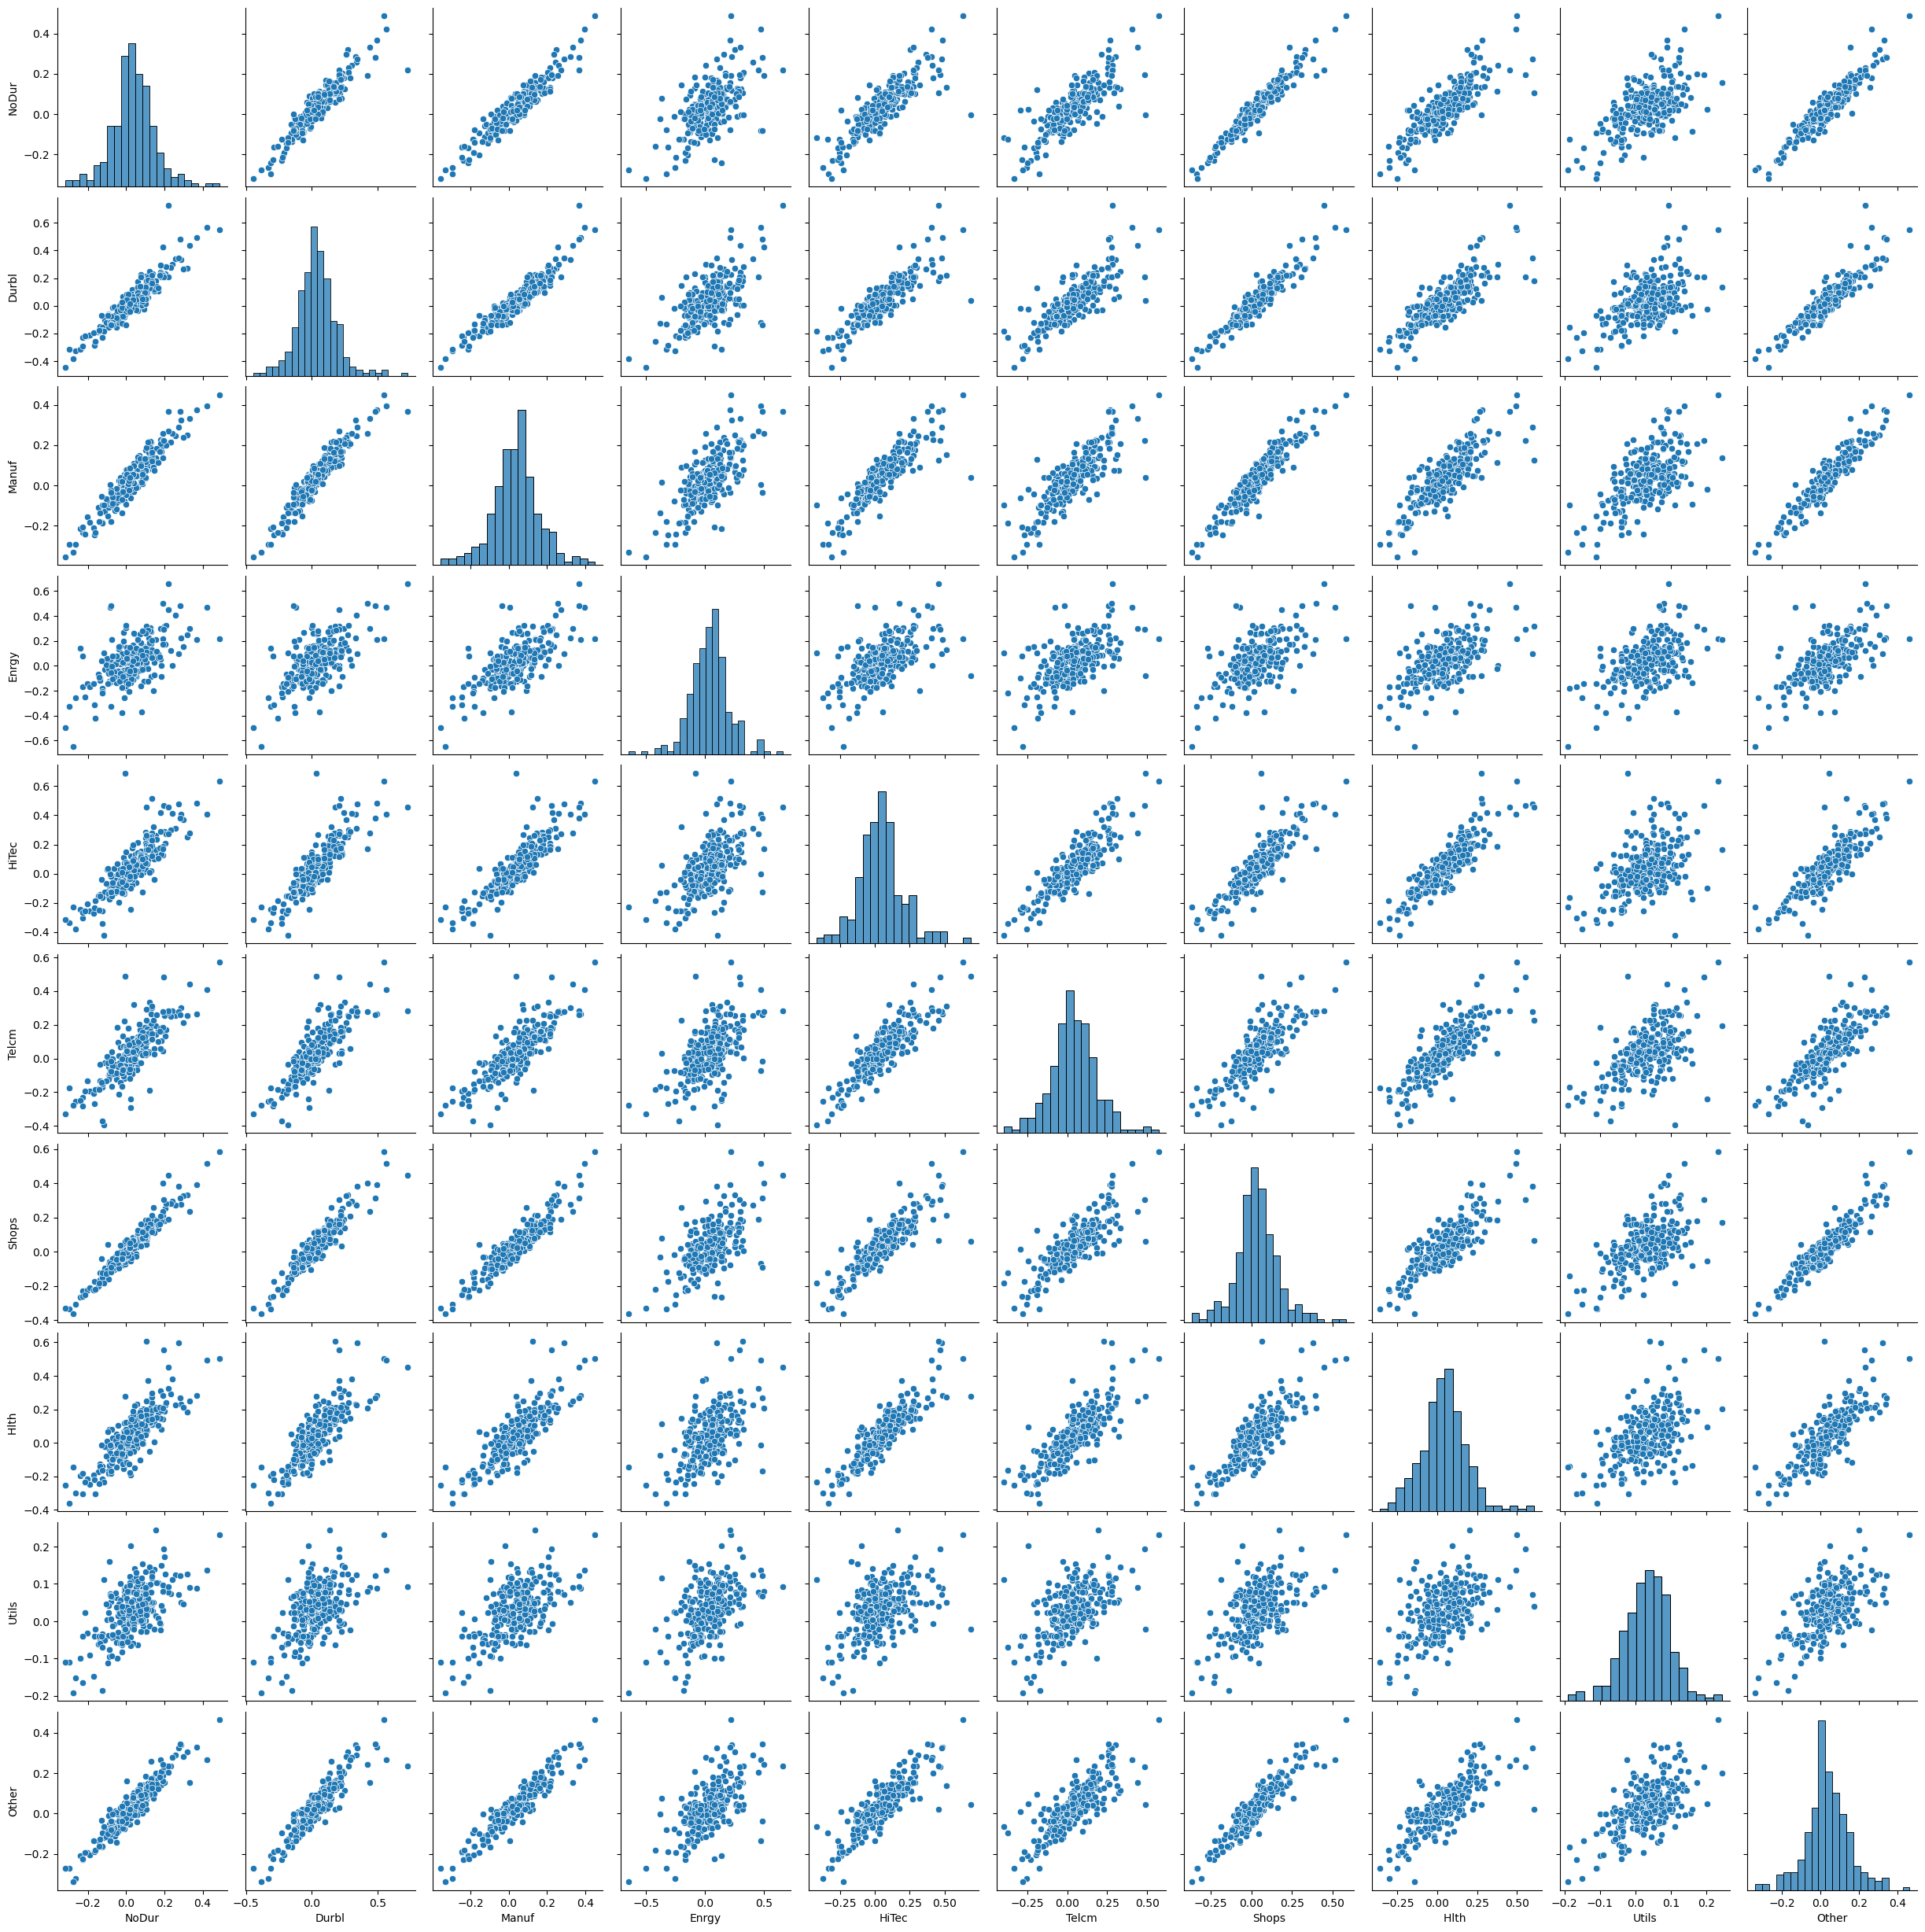

In [33]:
sns.pairplot(merged_df[industry_name])

A lot of strong, positive correlation. With the normal distributions, there seems to be somewhat a left skew.

We will now try and optimize these potfolios, coming straight from the book

In [42]:
merged_weighting = merged_df[industry_name]

In [43]:
mu = merged_weighting.mean().values
sigma = merged_weighting.cov().values

In [40]:
from numpy.linalg import inv

In [44]:
N = len(mu)
sigma_inv = inv(sigma)

A = mu.T @ sigma_inv @ mu
B = mu.T @ sigma_inv @ np.ones(N)
C = np.ones(N).T @ sigma_inv @ np.ones(N)

A, B, C

(0.25672940141370915, 7.408932560640984, 235.76037025716977)

In [54]:
#Portfolio Weights
w_tng = sigma_inv @ mu / B
w_gmv = sigma_inv @ np.ones(N) / C

pd.DataFrame({'tng': w_tng,
              'gmv': w_gmv},
             index=merged_weighting.columns).sort_values('tng', ascending=False)

,tng,gmv
Utils,0.904753,0.973553
Other,0.253975,0.128268
Manuf,0.231445,0.048475
Hlth,0.178954,0.003594
HiTec,0.014052,0.020250
Enrgy,-0.032329,-0.034841
Telcm,-0.037674,-0.071590
Shops,-0.065826,-0.138794
NoDur,-0.154708,0.225439
Durbl,-0.292642,-0.154354


The weights comparative to the tangency portfolio comparative to the global minimum variance portfolio are not that different from one another. This is kind of surprising, because looking at different returns across countries has very different numbers for each country when comparing the tangency portfolio to the GMV portfolio.